# Importing necessary libraries

In [8]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

## Loading the data

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/chest x-ray/chest_xray/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/chest x-ray/chest_xray/test'
val_dir = '/content/drive/MyDrive/Colab Notebooks/chest x-ray/chest_xray/val'
print("Dataset loaded!!")

Dataset loaded!!


## Basic Data information.

In [11]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("/content/drive/MyDrive/Colab Notebooks/chest x-ray/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/content/drive/MyDrive/Colab Notebooks/chest x-ray/chest_xray/train/PNEUMONIA"

Train set:
------------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8


# X-ray images having PNEUMONIA

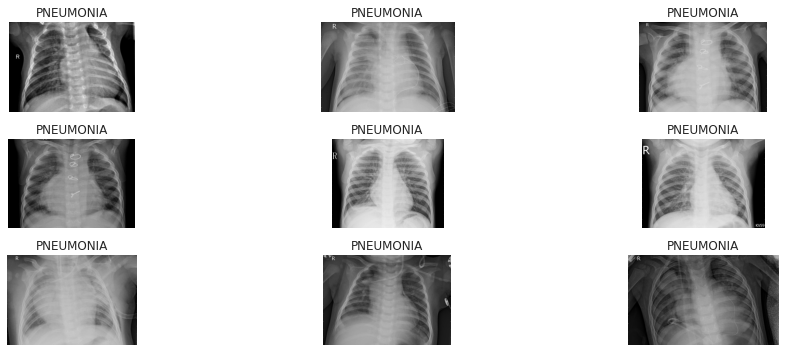

In [12]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

# NORMAL X-ray images

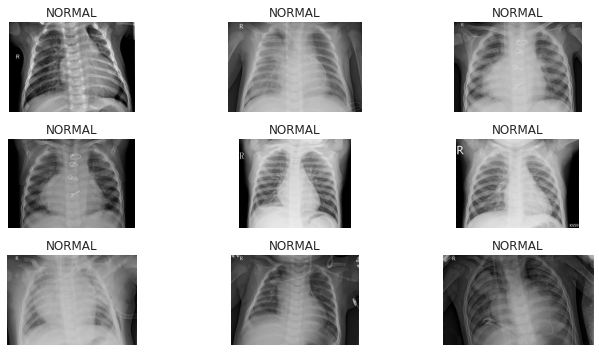

In [13]:
normal = os.listdir("/content/drive/MyDrive/Colab Notebooks/chest x-ray/chest_xray/chest_xray/train/NORMAL")
normal_dir = "/content/drive/MyDrive/Colab Notebooks/chest x-ray/chest_xray/chest_xray/train/NORMAL"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()


In [14]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

In [15]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

`0 - NORMAL || 1 - PNEUMONIA`

In [16]:
data.head()

,class
0,0
1,0
2,0
3,0
4,0


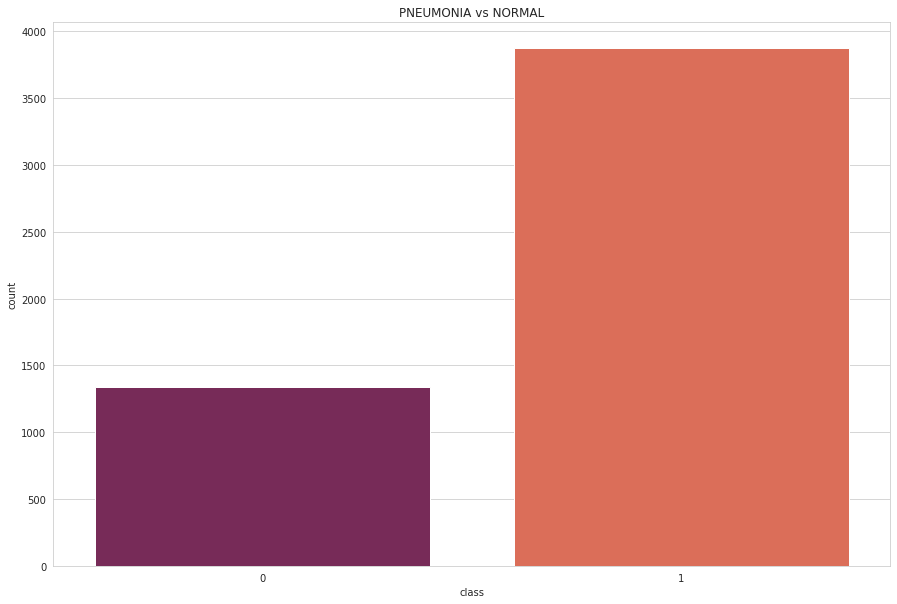

In [17]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

## Data Augmentation
-  `ImageDataGenerator`

In [18]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [19]:

train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
img, label = next(train)

# Defining the model
- `VGG19, ResNet50V2` model.


In [21]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [23]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 355s 3s/step - loss: 0.4814 - accuracy: 0.7650 - val_loss: 0.4641 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 162s 2s/step - loss: 0.4139 - accuracy: 0.8091 - val_loss: 0.4848 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 117s 1s/step - loss: 0.3954 - accuracy: 0.8122 - val_loss: 0.4901 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 98s 975ms/step - loss: 0.3625 - accuracy: 0.8325 - val_loss: 0.4682 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 97s 967ms/step - loss: 0.3433 - accuracy: 0.8394 - val_loss: 0.5189 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 91s 907ms/step - loss: 0.3305 - accuracy: 0.8516 - val_loss: 0.4082 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 92s 

# VGG19

In [24]:
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

163/163 [==============================] - 138s 845ms/step - loss: 0.2285 - accuracy: 0.9099
Train Loss:  0.22849516570568085
Train Accuracy:  0.9098926186561584


In [25]:
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

312/312 [==============================] - 146s 468ms/step - loss: 0.3499 - accuracy: 0.8365
Test Loss:  0.34994223713874817
Test Accuracy:  0.8365384340286255


Text(0.5, 1.0, 'Accuracy Evolution')

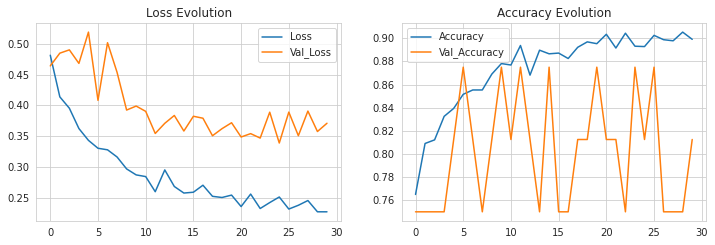

In [26]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# ResNet50V2

In [27]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

94683136/94668760 [==============================] - 2s 0us/step


In [28]:
history = model2.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 88s 838ms/step - loss: 0.2361 - accuracy: 0.8997 - val_loss: 0.1529 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 82s 822ms/step - loss: 0.2017 - accuracy: 0.9153 - val_loss: 0.1981 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 82s 814ms/step - loss: 0.1999 - accuracy: 0.9178 - val_loss: 0.1416 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 82s 824ms/step - loss: 0.1838 - accuracy: 0.9272 - val_loss: 0.2127 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 82s 824ms/step - loss: 0.1676 - accuracy: 0.9278 - val_loss: 0.1860 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 83s 826ms/step - loss: 0.1740 - accuracy: 0.9325 - val_loss: 0.1375 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/30
100/100 [==============================] 

In [29]:
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 137s 842ms/step - loss: 0.1288 - accuracy: 0.9507
Train Loss:  0.1288423091173172
Train Accuracy:  0.9507285356521606
312/312 [==============================] - 9s 29ms/step - loss: 0.1947 - accuracy: 0.9231

Test loss:  0.1946672797203064
Test Accuracy:  0.9230769276618958


Text(0.5, 1.0, 'Accuracy Evolution')

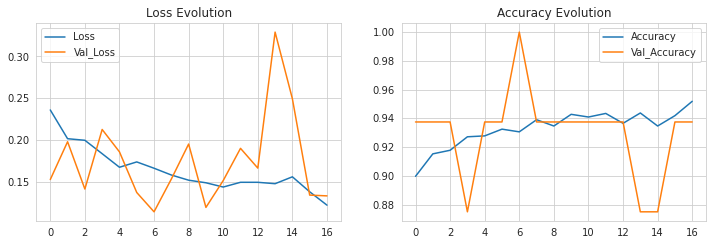

In [30]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [31]:
model.save('vgg19.h5')
model2.save('resnet50v2.h5')

# Fine Tuning

In [32]:
resnet_model.trainable = True
vgg_model.trainable = True

In [33]:
print("Number of layers in the base model: ", len(vgg_model.layers))

fine_tune_at = 100

for layer in vgg_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  22


In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [35]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [36]:
len(model.trainable_variables)

4

In [37]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - 87s 863ms/step - loss: 0.2426 - accuracy: 0.8994 - val_loss: 0.3551 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/40
100/100 [==============================] - 87s 868ms/step - loss: 0.2277 - accuracy: 0.9050 - val_loss: 0.3502 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/40
100/100 [==============================] - 86s 862ms/step - loss: 0.2309 - accuracy: 0.9034 - val_loss: 0.3363 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/40
100/100 [==============================] - 87s 865ms/step - loss: 0.2394 - accuracy: 0.9022 - val_loss: 0.3940 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/40
100/100 [==============================] - 88s 879ms/step - loss: 0.2312 - accuracy: 0.8988 - val_loss: 0.3475 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/40
100/100 [==============================] - 89s 890ms/step - loss: 0.2231 - accuracy: 0.9059 - val_loss: 0.3976 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/40
100/100 [==============================] 

# Evaluating the Fine Tune model

In [38]:
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 140s 855ms/step - loss: 0.2066 - accuracy: 0.9170
Train Loss:  0.20655235648155212
Train Accuracy:  0.9169861674308777
312/312 [==============================] - 9s 29ms/step - loss: 0.3016 - accuracy: 0.8846

Test loss:  0.3016376495361328
Test Accuracy:  0.8846153616905212


Text(0.5, 1.0, 'Accuracy Evolution')

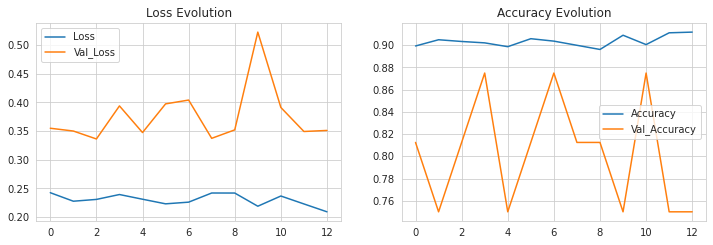

In [39]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [40]:
print("Number of layers in the base model: ", len(resnet_model.layers))

fine_tune_at = 100

for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [41]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [42]:
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [43]:
len(model2.trainable_variables)

86

In [44]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model2.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - 93s 868ms/step - loss: 0.3130 - accuracy: 0.8819 - val_loss: 0.3624 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/40
100/100 [==============================] - 88s 881ms/step - loss: 0.2239 - accuracy: 0.9197 - val_loss: 1.1893 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/40
100/100 [==============================] - 87s 862ms/step - loss: 0.1753 - accuracy: 0.9331 - val_loss: 4.3217 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/40
100/100 [==============================] - 87s 866ms/step - loss: 0.1521 - accuracy: 0.9391 - val_loss: 0.4170 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/40
100/100 [==============================] - 88s 875ms/step - loss: 0.1458 - accuracy: 0.9475 - val_loss: 0.7059 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/40
100/100 [==============================] - 87s 871ms/step - loss: 0.1402 - accuracy: 0.9509 - val_loss: 0.2638 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/40
100/100 [==============================] 

In [45]:
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 139s 849ms/step - loss: 0.0630 - accuracy: 0.9755
Train Loss:  0.0630359947681427
Train Accuracy:  0.9754601120948792
312/312 [==============================] - 9s 28ms/step - loss: 0.1630 - accuracy: 0.9407

Test loss:  0.16297775506973267
Test Accuracy:  0.9407051205635071


Text(0.5, 1.0, 'Accuracy Evolution')

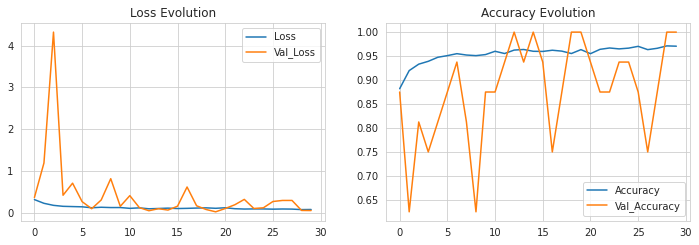

In [46]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [47]:
# Saving the fine tuned model
model.save('tuned_vgg19.h5')
model2.save('tuned_resnet.h5')

# Model evaluation

In [48]:
final_model = tf.keras.models.load_model('tuned_resnet.h5')

In [49]:
y_pred = final_model.predict(test)

In [50]:
final_model.evaluate(test)

312/312 [==============================] - 10s 28ms/step - loss: 0.1630 - accuracy: 0.9407


[0.16297782957553864, 0.9407051205635071]